# Setup Enviroment


In [ ]:
!pip install awscli
!pip install boto3 pydub pandas
!sudo apt install ffmpeg  # or brew install ffmpeg on Mac
!sudo apt-get install libsndfile1
!pip install soundfile
!pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 12.4 MB/s eta 0:00:00
Reading package lists... Done


In [ ]:
import os
from google.colab import userdata

os.environ["AWS_ACCESS_KEY_ID"] = userdata.get('AWS_ACCESS_KEY')
os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get('AWS_SECRET_KEY')
os.environ["AWS_DEFAULT_REGION"] = userdata.get('AWS_REGION_NAME')


In [ ]:
!aws configure list



      Name                    Value             Type    Location
      ----                    -----             ----    --------
   profile                <not set>             None    None
access_key     ****************M5FO              env    
secret_key     ****************VNpB              env    
    region               me-south-1              env    AWS_DEFAULT_REGION


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Handle audacity data

In [ ]:
!rm -rf content/_wav/

In [ ]:
# Requirements:
# !pip install boto3 pydub tqdm tabulate matplotlib
# !apt-get update && apt-get install -y ffmpeg

import os, re, json, math, logging, time, csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import Counter
import boto3, warnings
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from pydub import AudioSegment
import glob
import numpy as np


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [ ]:
#configurations

ROOT_PATH = "/content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA"
# S3 prefixes
S3_BUCKET = "widebot-ai"
S3_AUDIO_PREFIX = "TTS_V1/TTS_DATA_SA/audio"            # flat audio storage
S3_CSV_PREFIX   = "TTS_V1/TTS_DATA_SA"                  # CSV metadata uploaded here
S3_META_PREFIX  = "TTS_V1/TTS_DATA_SA_Metadata"         # analysis / missing / logs uploaded here

PREFIXES = ["TextToSpeech/Data/SA_Data"]

# persistent tmp (Drive recommended to allow resume across sessions)
TMP_BASE = "/content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1"
LOG_DIR = os.path.join(TMP_BASE, "logs")
STATE_DIR = os.path.join(TMP_BASE, "state")
TMP_WAV_DIR = os.path.join("/content/", "_wav")

SEQ_PADDING = 4            # zero-pad per-batch indexes
DRY_RUN = False            # True = no S3 uploads; set False to actually upload
MAX_WORKERS = 6            # concurrency for batches within a category
VERIF_THRESHOLD = 0.05     # seconds tolerance for verification warnings
PLOT_DASHBOARD = True      # show matplotlib bar chart

# batches with these tokens in name will be skipped
SKIP_PATTERNS = ["duplicate", "dup", "corrupt", "broken"]

# speaker mapping provided by you (fallback for categories)
SPEAKER_MAP = {
    "Cultural": "puck",
    "Furniture": "puck",
    "Hospital": "puck",
    "Saudi_issue_sentences": "puck",
    "Saudi_words_issues": "puck",
    "Second_batch": "puck",
    "Seramic": "puck",
    "Third_batch": "puck",
    "first_batch": "puck",
    "saudi_daily_life": "zephyr",
    "saudi_education": "zephyr",
    "saudi_food": "zephyr",
    "saudi_health": "zephyr",
    "saudi_transport": "zephyr",
    "saudi_work": "zephyr",
    "Saudi_Adam_Podcast": "puck",
    "Saudi_Computer_Reviews": "charon",
    "Saudi_Garema_Podcast": "charon",
    "Saudi_KenbaElsabt_Podcast": "leda",
    "Saudi_Wegdan_Podcast": "puck"
}

donot forget to add fetching data from S3 bucket
--> add flag refer to use (S3 bucket/drive link)

In [ ]:
#drive path --> tmp_base
def find_gsa_files(drive_path):
    """
    Find all CSV files starting with G_SA in Google Drive

    Args:
        search_path: Path to search in (default is MyDrive root)
    """
    print(f"Searching in: {drive_path}")
    print(f"Directory exists: {os.path.exists(drive_path)}")

    # List all files in the directory first (for debugging)
    if os.path.exists(drive_path):
        all_files = os.listdir(drive_path)
        print(f"\nAll files in directory: {len(all_files)} items")
        csv_files = [f for f in all_files if f.endswith('.csv')]
        print(f"CSV files found: {csv_files[:10]}")  # Show first 10

    files = []

    # Method 1: Search in current directory
    pattern1 = os.path.join(drive_path, 'G_SA*.csv')
    files1 = glob.glob(pattern1)
    files.extend(files1)

    # Method 2: Search in subdirectories
    pattern2 = os.path.join(drive_path, '**', 'G_SA*.csv')
    files2 = glob.glob(pattern2, recursive=True)
    files.extend(files2)

    # Remove duplicates
    files = list(set(files))

    if not files:
        print(f"\nNo files found starting with 'G_SA'")
        return []

    print(f"\nFound {len(files)} file(s) starting with 'G_SA':")
    for i, file in enumerate(files, 1):
        # Show relative path for readability
        rel_path = file.replace(TMP_BASE, '')
        print(f"{i}. {os.path.basename(file)} - {rel_path}")

    return files

In [ ]:
import pandas as pd
import os

def read_gsa_csv(file_path=None, drive_path=TMP_BASE):
    """
    Read G_SA file as raw text (no parsing, no splitting).
    Guaranteed no data loss.
    """
    if file_path is None:
        files = find_gsa_files(drive_path)

        if not files:
            return None

        file_path = files[0]
        print(f"\nReading: {file_path}")

    rows = []
    with open(file_path, encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            rows.append({
                "line_number": line_no,
                "text": line.rstrip("\n")
            })

    df = pd.DataFrame(rows)
    return df


In [ ]:
read_gsa_csv()

Searching in: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1
Directory exists: True

All files in directory: 81 items
CSV files found: ['G_SA_cultural.csv', 'analysis_G_SA_cultural.csv', 'missing_G_SA_cultural.csv', 'G_SA_furniture.csv', 'analysis_G_SA_furniture.csv', 'missing_G_SA_furniture.csv', 'G_SA_hospital.csv', 'analysis_G_SA_hospital.csv', 'missing_G_SA_hospital.csv', 'G_SA_saudi_adam_podcast.csv']

Found 24 file(s) starting with 'G_SA':
1. G_SA_saudi_education.csv - /G_SA_saudi_education.csv
2. G_SA_saudi_daily_life.csv - /G_SA_saudi_daily_life.csv
3. G_SA_seramic.csv - /G_SA_seramic.csv
4. G_SA_saudi_work.csv - /G_SA_saudi_work.csv
5. G_SA_saudi_words_issues.csv - /G_SA_saudi_words_issues.csv
6. G_SA_saudi_health.csv - /G_SA_saudi_health.csv
7. G_SA_saudi_adam_podcast.csv - /G_SA_saudi_adam_podcast.csv
8. G_SA_saudi_kenbaelsabt_podcast.csv - /G_SA_saudi_kenbaelsabt_podcast.csv
9. G_SA_saudi_phonemena.csv - /G_SA_saudi_phonemena.csv
10. G_SA_s

,line_number,text
0,1,audio_file|text|speaker_name
1,2,audio/G_SA_saudi_education_batch_11_0001.wav|ب...
2,3,audio/G_SA_saudi_education_batch_11_0002.wav|م...
3,4,audio/G_SA_saudi_education_batch_11_0003.wav|ا...
4,5,audio/G_SA_saudi_education_batch_11_0004.wav|ا...
...,...,...
1033,1034,audio/G_SA_saudi_education_batch_97_0014.wav|ا...
1034,1035,audio/G_SA_saudi_education_batch_97_0015.wav|ا...
1035,1036,audio/G_SA_saudi_education_batch_97_0016.wav|م...
1036,1037,audio/G_SA_saudi_education_batch_97_0017.wav|ب...


In [ ]:
df_v = read_gsa_csv()

Searching in: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1
Directory exists: True

All files in directory: 81 items
CSV files found: ['G_SA_cultural.csv', 'analysis_G_SA_cultural.csv', 'missing_G_SA_cultural.csv', 'G_SA_furniture.csv', 'analysis_G_SA_furniture.csv', 'missing_G_SA_furniture.csv', 'G_SA_hospital.csv', 'analysis_G_SA_hospital.csv', 'missing_G_SA_hospital.csv', 'G_SA_saudi_adam_podcast.csv']

Found 24 file(s) starting with 'G_SA':
1. G_SA_saudi_education.csv - /G_SA_saudi_education.csv
2. G_SA_saudi_daily_life.csv - /G_SA_saudi_daily_life.csv
3. G_SA_seramic.csv - /G_SA_seramic.csv
4. G_SA_saudi_work.csv - /G_SA_saudi_work.csv
5. G_SA_saudi_words_issues.csv - /G_SA_saudi_words_issues.csv
6. G_SA_saudi_health.csv - /G_SA_saudi_health.csv
7. G_SA_saudi_adam_podcast.csv - /G_SA_saudi_adam_podcast.csv
8. G_SA_saudi_kenbaelsabt_podcast.csv - /G_SA_saudi_kenbaelsabt_podcast.csv
9. G_SA_saudi_phonemena.csv - /G_SA_saudi_phonemena.csv
10. G_SA_s

In [ ]:
# df_invalid

In [ ]:
# read all files With G_SA
def read_all_gsa_files(drive_path=TMP_BASE, combine=True):
    """
    Read ALL G_SA files as raw text

    Args:
        drive_path: Directory containing the files
        combine: If True, combine all into one DataFrame with source column
                 If False, return dictionary of DataFrames
    """
    files = find_gsa_files(drive_path)

    if not files:
        return None

    dataframes = {}

    print(f"\n{'='*60}")
    print("READING ALL FILES")
    print(f"{'='*60}")

    for file_path in files:
        filename = os.path.basename(file_path)
        print(f"\nReading: {filename}")

        try:
            df_temp = read_gsa_csv(file_path=file_path)
            df_temp['source_file'] = filename
            dataframes[filename] = df_temp
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not dataframes:
        print("\nNo files were successfully read!")
        return None

    if combine:
        print(f"\n{'='*60}")
        print("COMBINING ALL FILES")
        print(f"{'='*60}")

        df_combined = pd.concat(dataframes.values(), ignore_index=True)

        print(f"\nCombined DataFrame:")
        print(f"  Total lines: {len(df_combined)}")
        print(f"  Columns: {df_combined.columns.tolist()}")
        print(f"\nFiles included:")
        print(df_combined['source_file'].value_counts())
        print(f"\nFirst 10 lines:")
        print(df_combined.head(10))

        return df_combined
    else:
        return dataframes


In [ ]:
df_all = read_all_gsa_files()

Searching in: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1
Directory exists: True

All files in directory: 81 items
CSV files found: ['G_SA_cultural.csv', 'analysis_G_SA_cultural.csv', 'missing_G_SA_cultural.csv', 'G_SA_furniture.csv', 'analysis_G_SA_furniture.csv', 'missing_G_SA_furniture.csv', 'G_SA_hospital.csv', 'analysis_G_SA_hospital.csv', 'missing_G_SA_hospital.csv', 'G_SA_saudi_adam_podcast.csv']

Found 24 file(s) starting with 'G_SA':
1. G_SA_saudi_education.csv - /G_SA_saudi_education.csv
2. G_SA_saudi_daily_life.csv - /G_SA_saudi_daily_life.csv
3. G_SA_seramic.csv - /G_SA_seramic.csv
4. G_SA_saudi_work.csv - /G_SA_saudi_work.csv
5. G_SA_saudi_words_issues.csv - /G_SA_saudi_words_issues.csv
6. G_SA_saudi_health.csv - /G_SA_saudi_health.csv
7. G_SA_saudi_adam_podcast.csv - /G_SA_saudi_adam_podcast.csv
8. G_SA_saudi_kenbaelsabt_podcast.csv - /G_SA_saudi_kenbaelsabt_podcast.csv
9. G_SA_saudi_phonemena.csv - /G_SA_saudi_phonemena.csv
10. G_SA_s

In [ ]:
def save_raw_data(df, output_path):
    """
    Save the raw text data to CSV
    Each row keeps the original pipe-delimited format
    """
    print(f"\n{'='*60}")
    print("SAVING RAW DATA")
    print(f"{'='*60}")
    print(f"Output: {output_path}")
    df.to_csv(output_path, index=False)
    print(f"Saved {len(df)} lines")
    return output_path

In [ ]:
read_all_gsa_files()

Searching in: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/MetaData_SA_T1
Directory exists: True

All files in directory: 81 items
CSV files found: ['G_SA_cultural.csv', 'analysis_G_SA_cultural.csv', 'missing_G_SA_cultural.csv', 'G_SA_furniture.csv', 'analysis_G_SA_furniture.csv', 'missing_G_SA_furniture.csv', 'G_SA_hospital.csv', 'analysis_G_SA_hospital.csv', 'missing_G_SA_hospital.csv', 'G_SA_saudi_adam_podcast.csv']

Found 24 file(s) starting with 'G_SA':
1. G_SA_saudi_education.csv - /G_SA_saudi_education.csv
2. G_SA_saudi_daily_life.csv - /G_SA_saudi_daily_life.csv
3. G_SA_seramic.csv - /G_SA_seramic.csv
4. G_SA_saudi_work.csv - /G_SA_saudi_work.csv
5. G_SA_saudi_words_issues.csv - /G_SA_saudi_words_issues.csv
6. G_SA_saudi_health.csv - /G_SA_saudi_health.csv
7. G_SA_saudi_adam_podcast.csv - /G_SA_saudi_adam_podcast.csv
8. G_SA_saudi_kenbaelsabt_podcast.csv - /G_SA_saudi_kenbaelsabt_podcast.csv
9. G_SA_saudi_phonemena.csv - /G_SA_saudi_phonemena.csv
10. G_SA_s

,line_number,text,source_file
0,1,audio_file|text|speaker_name,G_SA_saudi_education.csv
1,2,audio/G_SA_saudi_education_batch_11_0001.wav|ب...,G_SA_saudi_education.csv
2,3,audio/G_SA_saudi_education_batch_11_0002.wav|م...,G_SA_saudi_education.csv
3,4,audio/G_SA_saudi_education_batch_11_0003.wav|ا...,G_SA_saudi_education.csv
4,5,audio/G_SA_saudi_education_batch_11_0004.wav|ا...,G_SA_saudi_education.csv
...,...,...,...
26521,580,audio/G_SA_first_batch_batch_8_0020.wav|أهلاً ...,G_SA_first_batch.csv
26522,581,audio/G_SA_first_batch_batch_8_0021.wav|يا هلا...,G_SA_first_batch.csv
26523,582,audio/G_SA_first_batch_batch_8_0022.wav|أهلاً ...,G_SA_first_batch.csv
26524,583,audio/G_SA_first_batch_batch_8_0023.wav|أهلاً ...,G_SA_first_batch.csv


In [ ]:
raw_output = '/content/drive/MyDrive/Audio_data/combined_G_SA_raw.csv'
audio_output = '/content/drive/MyDrive/Audio_data/G_SA_audio_paths.csv'
parsed_output = '/content/drive/MyDrive/Audio_data/G_SA_parsed_full.csv'


In [ ]:
save_raw_data(df_all, raw_output)


SAVING RAW DATA
Output: /content/drive/MyDrive/Audio_data/combined_G_SA_raw.csv
Saved 26526 lines


'/content/drive/MyDrive/Audio_data/combined_G_SA_raw.csv'

In [ ]:
def extract_audio_paths(df, output_path):
    """
    Extract audio batch references and source files from the text column
    Removes: 'audio/' prefix and segment number
    Keeps: .wav extension and source_file column

    Example:
    Input:  audio/G_SA_saudi_words_issues_batch_10_0001.wav
    Output: G_SA_saudi_words_issues_batch_10.wav, G_SA_saudi_words_issues.csv
    """
    print(f"\n{'='*60}")
    print("EXTRACTING AUDIO BATCH REFERENCES")
    print(f"{'='*60}")

    # Skip header lines
    df_data = df[~df['text'].str.contains('audio_file\|text\|speaker_name', na=False)]

    # Extract audio path and clean it
    audio_data = []
    for idx, row in df_data.iterrows():
        text = row['text']
        source_file = row['source_file']

        if '|' in text:
            # Get everything before first pipe
            audio_path = text.split('|')[0]

            # Remove 'audio/' prefix
            audio_path = audio_path.replace('audio/', '')

            # Remove segment number (last _NNNN part before .wav)
            # Pattern: G_SA_category_batch_10_0001.wav -> G_SA_category_batch_10.wav
            if audio_path.endswith('.wav'):
                # Split by .wav to separate filename and extension
                filename = audio_path[:-4]  # Remove .wav
                # Remove last segment number (_NNNN)
                parts = filename.rsplit('_', 1)  # Split from right, only once
                if len(parts) == 2 and parts[1].isdigit():
                    audio_path = parts[0] + '.wav'

            audio_data.append({
                'audio_path': audio_path,
                'source_file': source_file
            })

    # Create DataFrame
    df_audio = pd.DataFrame(audio_data)

    # Remove duplicates (keep first occurrence)
    df_audio_unique = df_audio.drop_duplicates(subset=['audio_path'], keep='first')

    print(f"\nExtracted {len(audio_data)} total references")
    print(f"Unique batch references: {len(df_audio_unique)}")
    print(f"\nFirst 10 audio batch references:")
    print(df_audio_unique.head(10))

    # Save to CSV
    print(f"\nSaving to: {output_path}")
    df_audio_unique.to_csv(output_path, index=False)
    print(f"Saved {len(df_audio_unique)} unique audio batch references")

    return df_audio_unique

<>:16: SyntaxWarning: invalid escape sequence '\|'
<>:16: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-1951354512.py:16: SyntaxWarning: invalid escape sequence '\|'
  df_data = df[~df['text'].str.contains('audio_file\|text\|speaker_name', na=False)]


In [ ]:
df_audio_paths = extract_audio_paths(df_all, audio_output)



EXTRACTING AUDIO BATCH REFERENCES

Extracted 26502 total references
Unique batch references: 1510

First 10 audio batch references:
                            audio_path               source_file
0    G_SA_saudi_education_batch_11.wav  G_SA_saudi_education.csv
24   G_SA_saudi_education_batch_13.wav  G_SA_saudi_education.csv
46   G_SA_saudi_education_batch_10.wav  G_SA_saudi_education.csv
68    G_SA_saudi_education_batch_1.wav  G_SA_saudi_education.csv
92   G_SA_saudi_education_batch_12.wav  G_SA_saudi_education.csv
117   G_SA_saudi_education_batch_0.wav  G_SA_saudi_education.csv
142  G_SA_saudi_education_batch_16.wav  G_SA_saudi_education.csv
151  G_SA_saudi_education_batch_17.wav  G_SA_saudi_education.csv
167  G_SA_saudi_education_batch_15.wav  G_SA_saudi_education.csv
187  G_SA_saudi_education_batch_18.wav  G_SA_saudi_education.csv

Saving to: /content/drive/MyDrive/Audio_data/G_SA_audio_paths.csv
Saved 1510 unique audio batch references


In [ ]:
# Count audios per source_file
df_ = pd.read_csv(audio_output)

In [ ]:
print(f"Total (audios): {len(df_)}")

# Count audios per source_file
audio_per_source = (
    df_["source_file"]
    .value_counts()
    .reset_index()
)

audio_per_source.columns = ["source_file", "audio_count"]

# print("\nAudio count per source file:")
# print(audio_per_source)
audio_per_source["source_file_clean"] = (
    audio_per_source["source_file"]
    .str.replace("G_SA_", "", regex=False)
    .str.replace(".csv", "", regex=False)
)

Total (audios): 1510


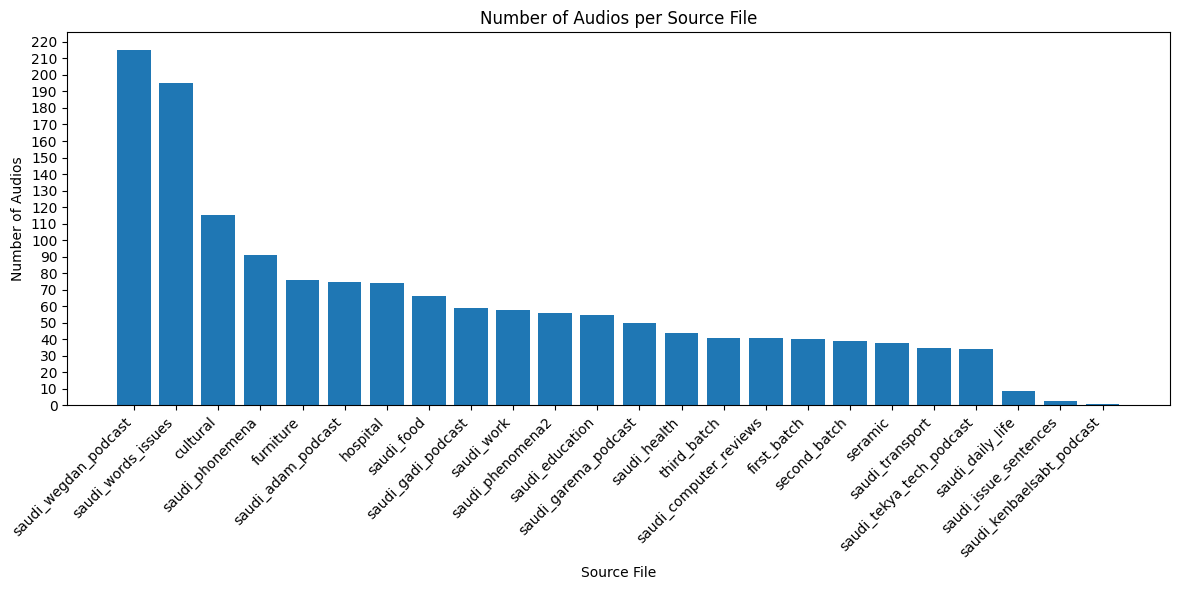

In [ ]:
# Get max value
max_count = audio_per_source["audio_count"].max()

# Create y-axis ticks: 0, 10, 20, ..., max
y_ticks = np.arange(0, max_count + 10, 10)

# Visualization
plt.figure(figsize=(12,6))
plt.bar(audio_per_source["source_file_clean"], audio_per_source["audio_count"])
plt.xticks(rotation=45, ha="right")
plt.yticks(y_ticks)
plt.xlabel("Source File")
plt.ylabel("Number of Audios")
plt.title("Number of Audios per Source File")
plt.tight_layout()
plt.show()

##Read and find audio path from drive

In [ ]:
AUDIO_PATHS_CSV = '/content/drive/MyDrive/Audio_data/audio_paths.csv'
OUTPUT_SRT_BASE = '/content/drive/MyDrive/Audio_data/STT_outputs'
os.makedirs(OUTPUT_SRT_BASE, exist_ok=True)

In [ ]:
def parse_audio_filename(audio_reference):
    """
    Parse audio reference to extract category and batch number

    Example:
    G_SA_saudi_wegdan_podcast_batch_10.wav
    """
    filename = audio_reference.replace('audio/', '')

    pattern = r'G_SA_(.+?)_batch_(\d+)\.wav'
    match = re.match(pattern, filename)

    if match:
        category = match.group(1)
        batch_num = match.group(2)
        return {
            'category': category,
            'batch_num': batch_num,
            'filename': filename
        }
    else:
        print(f"WARNING: Could not parse filename: {filename}")
        return None


In [ ]:
def get_actual_audio_path(audio_reference, base_path=ROOT_PATH):
    """
    Convert audio reference to actual file path

    Structure: SA/ → Category_name/ → Category_name_batch_num/ → Category_name_batch_num.wav

    Example:
    Input: 'audio/G_SA_saudi_words_issues_batch_10_0001.wav'
    Output: '/content/drive/.../SA/Saudi_words_issues/Saudi_words_issues_batch_10/Saudi_words_issues_batch_10.wav'

    NOTE: The actual file name is the batch folder name, NOT the CSV reference name!
    """
    parsed = parse_audio_filename(audio_reference)

    if parsed is None:
        return None

    # Capitalize ONLY the first character, keep rest as-is
    # saudi_words_issues → Saudi_words_issues
    category_capitalized = parsed['category'][0].upper() + parsed['category'][1:]

    # Folder name is: Category_name_batch_num (e.g., "Saudi_words_issues_batch_10")
    folder_name = f"{category_capitalized}_batch_{parsed['batch_num']}"

    # IMPORTANT: The actual WAV file name = folder name + .wav
    actual_filename = f"{folder_name}.wav"

    actual_path = os.path.join(
        base_path,
        category_capitalized,
        folder_name,
        actual_filename
    )

    return actual_path

In [ ]:
def verify_audio_files(df_audio, sample_size):
    """
    Verify that audio files exist in the expected locations
    """
    print(f"\n{'='*60}")
    print("VERIFYING FILE STRUCTURE")
    print(f"{'='*60}")

    sample = df_audio.head(sample_size)

    found = 0
    not_found = 0

    for idx, row in sample.iterrows():
        audio_ref = row['audio_path']
        actual_path = get_actual_audio_path(audio_ref)

        if actual_path and os.path.exists(actual_path):
            print(f"Found: {audio_ref}")
            found += 1
        else:
            print(f"NOT FOUND: {audio_ref}")
            print(f"  Expected at: {actual_path}")
            not_found += 1

    print(f"\nVerification result: {found}/{sample_size} files found")

    if not_found > 0:
        print(f"\nWARNING: {not_found} files not found!")
        print("Please check the directory structure.")
        return False
    else:
        print("\nAll sample files verified successfully!")
        return True

In [ ]:
print("Loading audio paths from CSV...")
df_audio = pd.read_csv(AUDIO_PATHS_CSV)
print(f"Loaded {len(df_audio)} audio references")


Loading audio paths from CSV...
Loaded 16266 audio references


In [ ]:
verify_audio_files(df_audio, sample_size=10)


VERIFYING FILE STRUCTURE
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/batch_1_0.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0000.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0001.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0002.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0003.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gemini_eg_0004.wav
  Expected at: None
NOT FOUND: /content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/first_batch/batch_1/eg_wav/Gem

False

In [ ]:
# try another way to read the audio path
def collect_wav_files(root_folder):
    """
    Collect all .wav files inside a folder and all subfolders
    """
    wav_files = []

    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(".wav"):
                wav_files.append({
                    "file_name": file,
                    "audio_path": os.path.join(root, file),
                    "folder": os.path.basename(root)
                })

    df = pd.DataFrame(wav_files)
    print(f"Found {len(df)} WAV files")
    return df

In [ ]:
df_paths = collect_wav_files(ROOT_PATH)
df_paths

Found 16266 WAV files


,file_name,audio_path,folder
0,batch_1_0.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,batch_1
1,Gemini_eg_0000.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav
2,Gemini_eg_0001.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav
3,Gemini_eg_0002.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav
4,Gemini_eg_0003.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav
...,...,...,...
16261,Saudi_Gadi_Podcast_batch_111.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,Saudi_Gadi_Podcast_batch_111
16262,Saudi_Gadi_Podcast_batch_109.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,Saudi_Gadi_Podcast_batch_109
16263,Saudi_Gadi_Podcast_batch_1.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,Saudi_Gadi_Podcast_batch_1
16264,Saudi_Gadi_Podcast_batch_104.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,Saudi_Gadi_Podcast_batch_104


In [ ]:
df_paths.to_csv(
    AUDIO_PATHS_CSV,
    index=False
)

In [ ]:
# verify_audio_files(df_audio, sample_size=10)

#whisper

In [ ]:
## whisper

In [ ]:
# setup_whisper()

In [ ]:
# import whisper
# from tqdm import tqdm
# import time

In [ ]:
%pip install faster-whisper


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
import os
import time
import pandas as pd
from tqdm import tqdm
from faster_whisper import WhisperModel


In [ ]:
# batching processing settings
BATCH_SIZE = 10
SAVE_AFTER_EACH_FILE = True


### To make the output in SRT files


In [ ]:
# def build_srt_path(audio_path):
#     # save the structure of folders
#     rel_path = os.path.relpath(audio_path, "/content/drive/MyDrive")
#     rel_path = os.path.splitext(rel_path)[0] + ".srt"
#     return os.path.join(OUTPUT_SRT_BASE, rel_path)


In [ ]:
# # convert the transcription into SRT
# def segments_to_srt(segments, srt_path):
#     os.makedirs(os.path.dirname(srt_path), exist_ok=True)

#     def format_time(seconds):
#         ms = int((seconds % 1) * 1000)
#         s = int(seconds)
#         h = s // 3600
#         m = (s % 3600) // 60
#         s = s % 60
#         return f"{h:02}:{m:02}:{s:02},{ms:03}"

#     with open(srt_path, "w", encoding="utf-8") as f:
#         for i, seg in enumerate(segments, 1):
#             f.write(f"{i}\n")
#             f.write(f"{format_time(seg.start)} --> {format_time(seg.end)}\n")
#             f.write(seg.text.strip() + "\n\n")


In [ ]:
# # for one file
# def transcribe_to_srt(audio_path, srt_path, model):
#     segments, _ = model.transcribe(
#         audio_path,
#         beam_size=5,
#         vad_filter=True
#     )
#     segments_to_srt(list(segments), srt_path)


In [ ]:
# def process_all_audios(
#     df_audio,
#     model_size="base",
#     save_every=20
# ):
#     print("PROCESSING AUDIO FILES")
#     print("=" * 60)

#     model = WhisperModel(
#         model_size,
#         device="cuda",
#         compute_type="float16"
#     )

#     log_path = os.path.join(OUTPUT_SRT_BASE, "processing_log.csv")
#     processed = set()

#     if os.path.exists(log_path):
#         try:
#             df_log = pd.read_csv(log_path)
#             if "audio_path" in df_log.columns:
#                 processed = set(df_log["audio_path"])
#                 print(f"Resuming: {len(processed)} files already processed")
#         except:
#             print("Could not read log file, starting fresh")

#     results = []
#     start_time = time.time()

#     for _, row in tqdm(df_audio.iterrows(), total=len(df_audio)):
#         audio_path = row["audio_path"]

#         if audio_path in processed:
#             continue

#         if not os.path.exists(audio_path):
#             results.append({
#                 "audio_path": audio_path,
#                 "status": "not_found"
#             })
#             continue

#         srt_path = build_srt_path(audio_path)

#         if os.path.exists(srt_path):
#             results.append({
#                 "audio_path": audio_path,
#                 "status": "already_exists",
#                 "srt_path": srt_path
#             })
#             processed.add(audio_path)
#             continue

#         try:
#             transcribe_to_srt(audio_path, srt_path, model)
#             results.append({
#                 "audio_path": audio_path,
#                 "status": "success",
#                 "srt_path": srt_path
#             })
#             processed.add(audio_path)

#         except Exception as e:
#             results.append({
#                 "audio_path": audio_path,
#                 "status": "error",
#                 "error": str(e)
#             })

#         if len(results) % save_every == 0:
#             pd.DataFrame(results).to_csv(log_path, index=False)

#     pd.DataFrame(results).to_csv(log_path, index=False)

#     elapsed = time.time() - start_time
#     print(f"Finished in {elapsed/60:.1f} minutes")

#     return pd.DataFrame(results)


In [ ]:
# just for testing
df_test = df_paths

In [ ]:
# process_all_audios(df_test, model_size="small")


### To make the output in csv file


In [ ]:
AUDIO_PATHS_CSV = '/content/drive/MyDrive/Audio_data/audio_paths.csv'
OUTPUT_CSV_BASE = '/content/drive/MyDrive/Audio_data/STT_CSVoutputs'


In [ ]:
CHECKPOINT_FILE = os.path.join(OUTPUT_CSV_BASE, "checkpoint.json")
FINAL_LOG_FILE = os.path.join(OUTPUT_CSV_BASE, "processing_log.csv")


In [ ]:
# Split Arabic text into sentences #   Splits on: . ؟ ! ،
def split_into_sentences(text):
    # Split on Arabic and English punctuation
    sentences = re.split(r'[.؟!،]+', text)

    # Clean and filter empty sentences
    sentences = [s.strip() for s in sentences if s.strip()]

    return sentences


In [ ]:
def extract_audio_filename_from_path(audio_path):
    filename = os.path.splitext(os.path.basename(audio_path))[0]
    if not filename.startswith("G_SA_"):
        filename = "G_SA_" + filename.lower()
    return filename

In [ ]:
# Create multiple CSV rows from one audio file
# Each sentence gets its own row with sequential numbering

def create_sentence_rows(audio_path, transcribed_text):
   # Extract base filename
    base_filename = extract_audio_filename_from_path(audio_path)

    # Split into sentences
    sentences = split_into_sentences(transcribed_text)

    # Create rows for each sentence
    rows = []
    for idx, sentence in enumerate(sentences, start=1):
        audio_file = f"audio/{base_filename}_{idx:04d}.wav"
        rows.append({
            "audio_file": audio_file,
            "text": sentence
        })

    return rows

In [ ]:
#  Maintain folder structure from input to output
#  Each audio gets its own CSV file in the corresponding output folder

def build_output_path(audio_path, base_input_dir, base_output_dir):
    # Get relative path starting from the audio root
    rel_path = os.path.relpath(audio_path, base_input_dir)

    # Replace extension with .csv
    rel_path = os.path.splitext(rel_path)[0] + ".csv"

    # Build output path
    output_path = os.path.join(base_output_dir, rel_path)

    # Ensure folders exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    return output_path


In [ ]:
def transcribe_audio_to_text(audio_path, model):

    segments, info = model.transcribe(
        audio_path,
        beam_size=3,
        vad_filter=True,
        # vad_parameters={
        # "threshold": 0.45,
        # "min_silence_duration_ms": 150
        # },
        language="ar"
    )

    # Join all segments
    full_text = " ".join([seg.text.strip() for seg in segments])
    return full_text.strip()

checkpoint management


In [ ]:
# # load processing checkpoint
# def load_checkpoint():
#     if os.path.exists(CHECKPOINT_FILE):
#         try:
#             with open(CHECKPOINT_FILE, 'r') as f:
#                 checkpoint = json.load(f)
#             print(f"Checkpoint loaded: {checkpoint['processed_count']} files already processed")
#             return checkpoint
#         except Exception as e:
#             print(f"Could not load checkpoint: {e}")

#     return {
#         "processed_files": [],
#         "processed_count": 0,
#         "last_batch": 0,
#         "results": []
#     }


In [ ]:
# # save checkpoint
# def save_checkpoint(checkpoint):
#     os.makedirs(os.path.dirname(CHECKPOINT_FILE), exist_ok=True)
#     with open(CHECKPOINT_FILE, 'w') as f:
#         json.dump(checkpoint, f, indent=2, ensure_ascii=False)


In [ ]:
# # save final results
# def save_final_results(results):
#     df_log = pd.DataFrame(results)
#     df_log.to_csv(FINAL_LOG_FILE, index=False)
#     print(f"Final log saved: {FINAL_LOG_FILE}")
#     return df_log


full pipeline in whisper

In [ ]:
# batch processing

In [ ]:
# def process_single_audio_to_csv(audio_path, output_csv_path, model):
#     """
#     Process one audio file:
#     1. Transcribe
#     2. Split into sentences
#     3. Save to its own CSV file

#     """
#     try:
#         # Transcribe
#         transcribed_text = transcribe_audio_to_text(audio_path, model)

#         # Split into sentence rows
#         rows = create_sentence_rows(audio_path, transcribed_text)

#         # Save to CSV
#         df = pd.DataFrame(rows)
#         df.to_csv(output_csv_path, sep="|", index=False, encoding="utf-8")

#         return {
#             "audio_path": audio_path,
#             "status": "success",
#             "output_csv": output_csv_path,
#             "num_sentences": len(rows)
#         }

#     except Exception as e:
#         return {
#             "audio_path": audio_path,
#             "status": "error",
#             "error": str(e)
#         }

In [ ]:
# def process_all_audios_to_csv(
#     df_audio,
#     output_csv_path,
#     model_size,
#     save_every,
#     batch_size,
#     ROOT_PATH,
#     OUTPUT_CSV_BASE
# ):
#     """
#     Process all audio files in BATCHES

#     ONLY CHANGE: Instead of processing files one by one sequentially,
#     we split them into batches and process each batch separately.

#     Args:
#         df_audio: DataFrame with 'audio_path' column
#         output_csv_path: Base path for output (kept for compatibility)
#         model_size: Whisper model size
#         save_every: Save log every N files
#         batch_size: NEW - Process files in batches of this size (default 10)
#         ROOT_PATH: Your root audio path
#         OUTPUT_CSV_BASE: Your output directory
#     """

#     print("PROCESSING AUDIO FILES TO CSV (BATCH MODE)")
#     print("=" * 70)
#     print(f" Total files: {len(df_audio)}")
#     print(f" Batch size: {batch_size}")
#     print("=" * 70)

#     # Load model
#     print(f"\n Loading Faster-Whisper model: {model_size}...")
#     model = WhisperModel(
#         model_size,
#         device="cpu",
#         compute_type="int8",
#         cpu_threads=os.cpu_count()
#     )
#     print(" Model loaded\n")

#     # Setup log
#     log_path = os.path.join(OUTPUT_CSV_BASE, "processing_log.csv")
#     processed = set()

#     if os.path.exists(log_path):
#         try:
#             df_log = pd.read_csv(log_path)
#             if "audio_path" in df_log.columns:
#                 processed = set(df_log["audio_path"])
#                 print(f" Resuming: {len(processed)} files already processed\n")
#         except:
#             print(" Starting fresh\n")

#     # Split dataframe into batches
#     total_files = len(df_audio)
#     num_batches = (total_files + batch_size - 1) // batch_size

#     log_rows = []
#     start_time = time.time()

#     # Process each batch
#     for batch_num in range(num_batches):
#         batch_start = batch_num * batch_size
#         batch_end = min(batch_start + batch_size, total_files)

#         # Get current batch of files
#         df_batch = df_audio.iloc[batch_start:batch_end]

#         print(f"\n{'='*70}")
#         print(f"BATCH {batch_num + 1}/{num_batches}")
#         print(f"Processing files {batch_start + 1} to {batch_end}")
#         print(f"{'='*70}\n")

#         # Process files in current batch
#         batch_progress = tqdm(
#             df_batch.iterrows(),
#             total=len(df_batch),
#             desc=f"Batch {batch_num + 1}/{num_batches}"
#         )

#         for idx, row in batch_progress:
#             audio_path = row["audio_path"]

#             # Skip if already processed
#             if audio_path in processed:
#                 continue

#             # Check if file exists
#             if not os.path.exists(audio_path):
#                 log_rows.append({
#                     "audio_path": audio_path,
#                     "status": "not_found"
#                 })
#                 continue

#             # Build output path
#             output_csv_path = build_output_path(audio_path, ROOT_PATH, OUTPUT_CSV_BASE)

#             # Process audio
#             result = process_single_audio_to_csv(audio_path, output_csv_path, model)
#             log_rows.append(result)
#             processed.add(audio_path)

#             # Save log periodically
#             if len(log_rows) % save_every == 0:
#                 pd.DataFrame(log_rows).to_csv(log_path, index=False)

#         # Save after each batch
#         pd.DataFrame(log_rows).to_csv(log_path, index=False)

#         # Batch summary
#         elapsed = time.time() - start_time
#         progress_pct = (batch_end / total_files) * 100

#         print(f"\nBatch {batch_num + 1} completed")
#         print(f" Progress: {progress_pct:.1f}% | Elapsed: {elapsed/60:.1f} min")

#     # Final summary (same as your original)
#     elapsed = time.time() - start_time
#     df_log = pd.DataFrame(log_rows)

#     print(f"\n{'=' * 70}")
#     print(" PROCESSING COMPLETE")
#     print(f"{'=' * 70}")
#     print(f" Total time: {elapsed/60:.1f} minutes")
#     print(f"\nStatus summary:")
#     print(df_log['status'].value_counts())

#     if 'num_sentences' in df_log.columns:
#         total_sentences = df_log['num_sentences'].sum()
#         print(f"\n Total sentences created: {total_sentences}")

#     print(f"\n{'=' * 70}")
#     print(" OUTPUT LOCATION")
#     print(f"{'=' * 70}")
#     print(f"CSV files saved to: {OUTPUT_CSV_BASE}")
#     print(f"Log file: {log_path}")

#     return df_log

In [ ]:
def process_all_audios_crash_resistant(
    df_audio,
    output_csv_path,
    model_size="medium",  # Changed from "medium" for speed
    ROOT_PATH = ROOT_PATH,
    OUTPUT_CSV_BASE = OUTPUT_CSV_BASE
):
    """
    CRASH-RESISTANT + FASTER audio processing

    Key improvements:
    1. Saves after EVERY file (restart from last processed)
    2. Uses "small" model by default (2-3x faster than "medium")
    3. Reduced beam_size for speed
    4. Tracks progress in real-time

    Args:
        df_audio: DataFrame with 'audio_path' column
        model_size: "tiny", "base", "small", "medium", or "large"
                   (smaller = faster, lower accuracy)
    """

    print("=" * 70)
    print("CRASH-RESISTANT AUDIO PROCESSING")
    print("=" * 70)
    print(f"Total files: {len(df_audio)}")
    print(f"Model: {model_size}")
    print("=" * 70)

    # Setup log path
    log_path = os.path.join(OUTPUT_CSV_BASE, "processing_log.csv")
    os.makedirs(OUTPUT_CSV_BASE, exist_ok=True)

    # Load checkpoint
    processed = set()
    log_rows = []

    if os.path.exists(log_path):
        try:
            df_log = pd.read_csv(log_path)
            if "audio_path" in df_log.columns:
                processed = set(df_log["audio_path"])
                log_rows = df_log.to_dict('records')
                print(f"\n✓ RESUMING: {len(processed)} files already processed")
                print(f"✓ Remaining: {len(df_audio) - len(processed)} files\n")
        except Exception as e:
            print(f"⚠ Could not load checkpoint: {e}")
            print("Starting fresh...\n")

    # Load Whisper model
    print(f"Loading Faster-Whisper '{model_size}' model...")
    model = WhisperModel(
        model_size,
        device="cpu",
        compute_type="int8",
        cpu_threads=os.cpu_count()
    )
    print("✓ Model loaded successfully\n")

    # Start processing
    start_time = time.time()
    files_processed = 0

    for idx, row in tqdm(df_audio.iterrows(), total=len(df_audio), desc="Processing"):
        audio_path = row["audio_path"]

        # Skip if already done
        if audio_path in processed:
            continue

        # Check file exists
        if not os.path.exists(audio_path):
            log_rows.append({
                "audio_path": audio_path,
                "status": "not_found"
            })
            pd.DataFrame(log_rows).to_csv(log_path, index=False)
            continue

        # Build output path
        output_csv_path_file = build_output_path(audio_path, ROOT_PATH, OUTPUT_CSV_BASE)

        # Process audio
        try:
            # Transcribe with FASTER settings
            segments, info = model.transcribe(
                audio_path,
                beam_size=3,
                vad_filter=True,
                language="ar"
            )

            # Join segments
            full_text = " ".join([seg.text.strip() for seg in segments])

            # Split into sentences
            base_filename = extract_audio_filename_from_path(audio_path)
            sentences = split_into_sentences(full_text)

            # Create CSV rows
            rows = []
            for i, sentence in enumerate(sentences, start=1):
                audio_file = f"audio/{base_filename}_{i:04d}.wav"
                rows.append({
                    "audio_file": audio_file,
                    "text": sentence
                })

            # Save CSV
            df_output = pd.DataFrame(rows)
            df_output.to_csv(output_csv_path_file, sep="|", index=False, encoding="utf-8")

            # Log success
            result = {
                "audio_path": audio_path,
                "status": "success",
                "output_csv": output_csv_path_file,
                "num_sentences": len(rows)
            }

        except Exception as e:
            result = {
                "audio_path": audio_path,
                "status": "error",
                "error": str(e)
            }

        # Update log
        log_rows.append(result)
        processed.add(audio_path)
        files_processed += 1

        # CRITICAL: Save after EVERY file
        pd.DataFrame(log_rows).to_csv(log_path, index=False)

        # Progress update every 10 files
        if files_processed % 10 == 0:
            elapsed = time.time() - start_time
            rate = files_processed / elapsed
            remaining = len(df_audio) - len(processed)
            eta = remaining / rate if rate > 0 else 0

            print(f"\n✓ Progress: {files_processed} files | "
                  f"Rate: {rate:.2f} files/sec | "
                  f"ETA: {eta/60:.1f} min")

    # Final summary
    elapsed = time.time() - start_time
    df_log = pd.DataFrame(log_rows)

    print(f"\n{'=' * 70}")
    print("✓ PROCESSING COMPLETE")
    print(f"{'=' * 70}")
    print(f"Total time: {elapsed/60:.1f} minutes")
    print(f"Average: {elapsed/len(df_audio):.2f} sec/file")
    print(f"\nStatus summary:")
    print(df_log['status'].value_counts())

    if 'num_sentences' in df_log.columns:
        total_sentences = df_log['num_sentences'].sum()
        print(f"\nTotal sentences: {total_sentences}")

    print(f"\n{'=' * 70}")
    print(f"Output: {OUTPUT_CSV_BASE}")
    print(f"Log: {log_path}")
    print(f"{'=' * 70}")

    return df_log


test first 2 audios

In [ ]:
#just for testing  '/content/drive/MyDrive/Generated Data/TTS/Gemini_audacity/To - AI/SA/Cultural/batch_0/saudi_culutral_topic_batch_0_0.wav'
df_audioTE = df_paths.head(2)
df_audioTE

,file_name,audio_path,folder
0,batch_1_0.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,batch_1
1,Gemini_eg_0000.wav,/content/drive/MyDrive/Generated Data/TTS/Gemi...,eg_wav


Start full processing

In [ ]:
#
log_df = process_all_audios_crash_resistant(
    df_audio=df_paths,     #    df_audioTE
    output_csv_path=OUTPUT_CSV_BASE,
    model_size="whisper-medium",
    ROOT_PATH=ROOT_PATH,
    OUTPUT_CSV_BASE=OUTPUT_CSV_BASE
)

CRASH-RESISTANT AUDIO PROCESSING
Total files: 16266
Model: medium

✓ RESUMING: 1084 files already processed
✓ Remaining: 15182 files

Loading Faster-Whisper 'medium' model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocabulary.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.bin:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

✓ Model loaded successfully



Processing:   7%|▋         | 1094/16266 [05:04<8:30:56,  2.02s/it]


✓ Progress: 10 files | Rate: 0.03 files/sec | ETA: 7688.4 min


Processing:   7%|▋         | 1104/16266 [09:50<91:18:47, 21.68s/it]


✓ Progress: 20 files | Rate: 0.03 files/sec | ETA: 7455.5 min


Processing:   7%|▋         | 1114/16266 [24:18<625:24:31, 148.59s/it]


✓ Progress: 30 files | Rate: 0.02 files/sec | ETA: 12277.2 min


Processing:   7%|▋         | 1124/16266 [29:00<135:57:23, 32.32s/it]


✓ Progress: 40 files | Rate: 0.02 files/sec | ETA: 10981.5 min


Processing:   7%|▋         | 1134/16266 [33:51<113:49:55, 27.08s/it]


✓ Progress: 50 files | Rate: 0.02 files/sec | ETA: 10244.5 min


Processing:   7%|▋         | 1144/16266 [38:47<127:07:58, 30.27s/it]


✓ Progress: 60 files | Rate: 0.03 files/sec | ETA: 9778.5 min


Processing:   7%|▋         | 1154/16266 [43:33<118:39:52, 28.27s/it]


✓ Progress: 70 files | Rate: 0.03 files/sec | ETA: 9402.9 min


Processing:   7%|▋         | 1164/16266 [48:25<120:04:29, 28.62s/it]


✓ Progress: 80 files | Rate: 0.03 files/sec | ETA: 9142.2 min


Processing:   7%|▋         | 1174/16266 [1:04:49<266:43:59, 63.63s/it]


✓ Progress: 90 files | Rate: 0.02 files/sec | ETA: 10869.5 min


Processing:   7%|▋         | 1184/16266 [1:09:36<118:17:36, 28.24s/it]


✓ Progress: 100 files | Rate: 0.02 files/sec | ETA: 10497.5 min


Processing:   7%|▋         | 1194/16266 [1:14:21<118:27:41, 28.29s/it]


✓ Progress: 110 files | Rate: 0.02 files/sec | ETA: 10188.5 min


Processing:   7%|▋         | 1204/16266 [1:18:51<116:28:06, 27.84s/it]


✓ Progress: 120 files | Rate: 0.03 files/sec | ETA: 9899.0 min


Processing:   7%|▋         | 1214/16266 [1:23:50<121:38:48, 29.09s/it]


✓ Progress: 130 files | Rate: 0.03 files/sec | ETA: 9707.2 min


Processing:   8%|▊         | 1224/16266 [1:28:31<119:55:49, 28.70s/it]


✓ Progress: 140 files | Rate: 0.03 files/sec | ETA: 9511.8 min


Processing:   8%|▊         | 1234/16266 [1:33:12<111:36:09, 26.73s/it]


✓ Progress: 150 files | Rate: 0.03 files/sec | ETA: 9340.0 min


Processing:   8%|▊         | 1244/16266 [1:38:01<117:49:54, 28.24s/it]


✓ Progress: 160 files | Rate: 0.03 files/sec | ETA: 9203.8 min


Processing:   8%|▊         | 1254/16266 [1:49:39<369:48:42, 88.68s/it] 


✓ Progress: 170 files | Rate: 0.03 files/sec | ETA: 9683.9 min


Processing:   8%|▊         | 1264/16266 [1:54:15<125:37:25, 30.15s/it]


✓ Progress: 180 files | Rate: 0.03 files/sec | ETA: 9522.7 min


Processing:   8%|▊         | 1274/16266 [1:58:57<116:25:50, 27.96s/it]


✓ Progress: 190 files | Rate: 0.03 files/sec | ETA: 9386.6 min


Processing:   8%|▊         | 1275/16266 [1:59:26<118:07:11, 28.37s/it]

In [ ]:
print("\nProcessing Summary:")
print(log_df['status'].value_counts())

___________________


# combination

In [ ]:
raw_output = '/content/drive/MyDrive/Audio_data/combined_G_SA_raw.csv'
wh_out = '/content/drive/MyDrive/Audio_data/STT_CSVoutputs'

annotated_output_csv = '/content/drive/MyDrive/Audio_data/combined_G_SA_annotated.csv'
annotated_output_json = '/content/drive/MyDrive/Audio_data/combined_G_SA_annotated.json'

whisper_output_csv = '/content/drive/MyDrive/Audio_data/combined_whisper.csv'
whisper_output_json = '/content/drive/MyDrive/Audio_data/combined_whisper.json'

commbined_output_csv = '/content/drive/MyDrive/Audio_data/a_w_data_ready.csv'

In [ ]:
import pandas as pd
import re
from pathlib import Path


In [ ]:
def read_and_combine_annotation_csv_fast(input_csv_path: str):

    df = pd.read_csv(input_csv_path)

    combined = {}

    for raw_text in df["text"].astype(str):
        if raw_text.startswith("audio_file"):
            continue

        parts = raw_text.split("|")
        if len(parts) < 2:
            continue

        audio_path, text = parts[0], parts[1]
        file_name = Path(audio_path).name

        match = re.search(r"(.*_batch_\d+)_\d+\.wav", file_name)
        if not match:
            continue

        batch_name = match.group(1).replace("G_SA_", "")
        segment_number = int(
            re.search(r"_(\d+)\.wav", file_name).group(1)
        )

        combined.setdefault(batch_name, []).append(
            (segment_number, text.strip())
        )

    rows = []
    for batch, segments in combined.items():
        segments.sort(key=lambda x: x[0])
        rows.append({
            "batch_name": batch,
            "full_text": " ".join(s[1] for s in segments)
        })

    return pd.DataFrame(rows)

In [ ]:
r_c_annoted = read_and_combine_annotation_csv_fast(raw_output)

In [ ]:
def save_batch_level_outputs(
    df: pd.DataFrame,
    output_csv_path: str,
    output_json_path: str
):
    df.to_csv(output_csv_path, index=False, encoding="utf-8-sig")
    df.to_json(output_json_path, orient="records", force_ascii=False, indent=2)


In [ ]:
save_batch_level_outputs(r_c_annoted, annotated_output_csv,annotated_output_json)

In [ ]:
# Recursively reads ALL folders.
    # Any CSV found:
    #   - extracts REAL text after '|'
    #   - combines into batch-level text
    # Output format matches annotation:
    # [batch_name, full_text]
def read_and_combine_whisper_outputs(base_dir: str):
    base_path = Path(base_dir)
    rows = []

    for folder in base_path.rglob("*"):
        if not folder.is_dir():
            continue

        csv_files = list(folder.glob("*.csv"))
        if not csv_files:
            continue

        category_name = folder.parent.name
        batch_name = folder.name
        combined_name = f"{category_name}_{batch_name}"

        all_texts = []

        for csv_file in sorted(csv_files):
            df = pd.read_csv(csv_file)

            if "audio_file|text" not in df.columns or df.empty:
                continue

            for raw in df["audio_file|text"].dropna().astype(str):

                clean_text = raw.split("|", 1)[1].strip() if "|" in raw else raw.strip()
                if clean_text:
                    all_texts.append(clean_text)

        if all_texts:
            rows.append({
                "batch_name": combined_name,
                "full_text": " ".join(all_texts)
            })

    return pd.DataFrame(rows)

In [ ]:
read_and_combine_whisper_outputs(wh_out)

In [ ]:
r_c_whisp = read_and_combine_whisper_outputs(wh_out)

In [ ]:
save_batch_level_outputs(r_c_whisp, whisper_output_csv, whisper_output_json)

## Clean (annotated data and whisper)
removing any symbles

In [ ]:
# 1. Function to clean text
# Removes all symbols/punctuation from text, Keeps letters, numbers, and spaces.
def clean_text(text: str) -> str:
    cleaned = re.sub(r'[^A-Za-z0-9ء-ي\s]', '', text)  # letters, numbers, spaces
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()    # normalize spaces
    return cleaned

In [ ]:
df_annotated = pd.read_csv(annotated_output_csv)

df_whisper = pd.read_csv(whisper_output_csv)

In [ ]:
# Keep only batch_name columns that exist in both
common_batches = pd.merge(df_annotated, df_whisper, on="batch_name", suffixes=("_annotated", "_whisper"))


In [ ]:
common_batches

In [ ]:
# 4. Clean the text columns
common_batches["full_text_annotated"] = common_batches["full_text_annotated"].astype(str).apply(clean_text)
common_batches["full_text_whisper"] = common_batches["full_text_whisper"].astype(str).apply(clean_text)


In [ ]:
# 5. Save result
output_path = commbined_output_csv
common_batches.to_csv(output_path, index=False)

# start to calculate similarity

In [ ]:
import pandas as pd
import re
import json
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
def jaccard_similarity(text1: str, text2: str) -> float:
    set1 = set(text1.split())
    set2 = set(text2.split())
    if not set1 or not set2:
        return 0.0
    return len(set1 & set2) / len(set1 | set2)


In [ ]:
def cosine_similarity_tfidf(text1: str, text2: str) -> float:
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf[0], tfidf[1])[0][0]


In [ ]:
def normalized_levenshtein(text1: str, text2: str) -> float:
    matcher = SequenceMatcher(None, text1, text2)
    return matcher.ratio()


In [ ]:
def wer(reference: str, hypothesis: str) -> float:
    ref = reference.split()
    hyp = hypothesis.split()

    d = [[0] * (len(hyp) + 1) for _ in range(len(ref) + 1)]

    for i in range(len(ref) + 1):
        d[i][0] = i
    for j in range(len(hyp) + 1):
        d[0][j] = j

    for i in range(1, len(ref) + 1):
        for j in range(1, len(hyp) + 1):
            cost = 0 if ref[i - 1] == hyp[j - 1] else 1
            d[i][j] = min(
                d[i - 1][j] + 1,
                d[i][j - 1] + 1,
                d[i - 1][j - 1] + cost
            )

    return d[len(ref)][len(hyp)] / max(len(ref), 1)


In [ ]:
evaluate_similarity_csv = '/content/drive/MyDrive/Audio_data/a_w_similarity_scores.csv'
evaluate_similarity_json = '/content/drive/MyDrive/Audio_data/a_w_similarity_scores.json'

In [ ]:
def evaluate_similarity(
    input_csv: str,
    output_csv: str,
    output_json: str
):
    df = pd.read_csv(input_csv)

    results = []

    for _, row in df.iterrows():
        annotated = clean_text(row["full_text_annotated"])
        whisper = clean_text(row["full_text_whisper"])

        metrics = {
            "batch_name": row["batch_name"],
            "jaccard": jaccard_similarity(annotated, whisper),
            "cosine": cosine_similarity_tfidf(annotated, whisper),
            "levenshtein": normalized_levenshtein(annotated, whisper),
            "wer": wer(annotated, whisper)
        }

        results.append(metrics)

    result_df = pd.DataFrame(results)

    # Save CSV
    result_df.to_csv(output_csv, index=False)

    # Save JSON
    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)

    return result_df


In [ ]:
evaluate_similarity(commbined_output_csv, evaluate_similarity_csv, evaluate_similarity_json)

Categorize batches

In [ ]:
def assign_category(match_percent: float) -> str:
    if match_percent >= 95:
        return "Excellent"
    elif 85 <= match_percent < 95:
        return "Good"
    elif 70 <= match_percent < 85:
        return "Warning"
    else:
        return "Critical"

In [ ]:
def categorize_batches(input_csv: str, output_csv: str, output_json: str):
    # Read metrics CSV (should have 'batch_name' and 'wer')
    df = pd.read_csv(input_csv)

    # Calculate Match % based on WER
    df["match_percent"] = (1 - df["wer"]) * 100

    # Assign category
    df["category"] = df["match_percent"].apply(assign_category)

    # Save CSV
    df.to_csv(output_csv, index=False)

    # Save JSON
    df.to_json(output_json, orient="records", force_ascii=False, indent=2)

    print(f"Categorized results saved to: {output_csv} and {output_json}")
    return df

In [ ]:
scores_csv = '/content/drive/MyDrive/Audio_data/a_w_similarity_scores.csv'
scores_json = '/content/drive/MyDrive/Audio_data/a_w_similarity_scores.json'

In [ ]:
results= categorize_batches(evaluate_similarity_csv, scores_csv,scores_json)

In [ ]:
# results.head(10)

visualization

In [ ]:
df = pd.read_csv(scores_csv)

# Count number of batches in each category
category_counts = df["category"].value_counts().reindex(
    ["Excellent", "Good", "Warning", "Critical"], fill_value=0
)

print(category_counts)

# ----------------------
# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette=["green","yellow","orange","red"])
plt.title("Number of Batches per WER Category")
plt.xlabel("Category")
plt.ylabel("Number of Batches")
plt.show()

#omnilingual
